In [2]:
from pandas import read_csv
from xgboost import XGBClassifier 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid
from sklearn.model_selection import cross_val_score
import time
import numpy as np
from matplotlib import pyplot
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, auc





In [3]:
# load data
train_data = read_csv('train.csv')
#test_data = read_csv('test.csv')

In [4]:
# Training data dimensions
print(train_data.shape)
#print(test_data.shape)


(61878, 95)


In [5]:
# SAMPLE 10 Rows from training dataset
train_data.sample(n=10)

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
47044,47045,0,0,0,0,0,0,3,0,0,...,3,1,2,1,0,0,0,0,0,Class_7
19151,19152,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Class_3
46686,46687,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,Class_7
2543,2544,0,0,0,0,0,0,0,0,0,...,0,2,1,0,0,0,0,1,0,Class_2
1108,1109,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
46527,46528,0,0,0,0,0,0,1,1,0,...,2,0,3,0,0,0,0,0,1,Class_7
702,703,1,0,0,0,0,0,0,6,0,...,0,0,0,0,1,0,0,0,0,Class_1
22028,22029,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,Class_3
30460,30461,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_5
36525,36526,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Class_6


Each *column* represents a feature measured by an integer. Each *row* is an **Otto** product.
The **Class Labels (targets)** are provided as character string in the last column. The **Otto** challenge is a multi class classification challenge.

In [6]:
# checking datatypes of Training columns
train_data.dtypes

id          int64
feat_1      int64
feat_2      int64
feat_3      int64
feat_4      int64
            ...  
feat_90     int64
feat_91     int64
feat_92     int64
feat_93     int64
target     object
Length: 95, dtype: object

In [7]:
# split data into X(features) and y(target labels)
X = train_data.values[:, 1:94]
y = train_data.values[:,94]

print("Input Features \n", X, "\n\n Target Labels \n", y)

Input Features 
 [[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 3 10 0]
 [0 0 0 ... 0 2 0]] 

 Target Labels 
 ['Class_1' 'Class_1' 'Class_1' ... 'Class_9' 'Class_9' 'Class_9']


The classes are provided as character string in the **target column**. **XGBoost** doesn't support anything else than numbers. So we will convert classes to integers. Moreover, according to the documentation, it should start at 0.


In [8]:
# encode string class values as integers, a
label_encoded_y = LabelEncoder().fit_transform(y)
print(label_encoded_y)

# Check no. of unique labels
np.unique(label_encoded_y)

[0 0 0 ... 8 8 8]


array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [9]:
"""Splitting data into train and test sets"""
train_X, valid_X, train_labels, valid_labels = model_selection.train_test_split(X, label_encoded_y,
                                                                                shuffle=True, test_size=0.20,
                                                                                random_state=42, 
                                                                                stratify= label_encoded_y)

Before the learning we will use the cross validation to evaluate the our error rate.

Basically **XGBoost** will divide the training data in `nfold` parts, then **XGBoost** will retain the first part and use it as the test data. Then it will reintegrate the first part to the training dataset and retain the second part, do a training and so on...

## Parallel Thread XGBoost, Parallel Thread Cross-Validation



In [182]:
# Building GRID SEARCH 
GS_model = XGBClassifier(objective= "multi:softprob",booster='gbtree',  n_jobs=-1)

subsample = [0.80, 1]
#learning_rate = [0.1, 0.2]
#max_depth = [2,3]
#min_child_weight = [1, 1.2]
#gamma = [0, 0.15]

param_grid = dict(subsample = subsample)
pg = ParameterGrid(param_grid)
len(pg)

2

In [183]:
start = time.time()
kfold = StratifiedKFold(n_splits = 3, shuffle=True, random_state=42)
grid_search = GridSearchCV(GS_model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(train_X, train_labels)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
elapsed = time.time() - start
print("Parallel Thread XGBoost, Parallel Thread CV, Elapsed Time: %f" % (elapsed))


Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.4min finished


Best: -0.651856 using {'subsample': 0.8}
Parallel Thread XGBoost, Parallel Thread CV: 304.441287


In [184]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.651856 using {'subsample': 0.8}
-0.651856 (0.002537) with: {'subsample': 0.8}
-0.658526 (0.001935) with: {'subsample': 1}


In [21]:
len(valid_X), len(valid_labels)

(12376, 12376)

## Single Thread XGBoost, Single Thread Cross-Validation


In [26]:
# Building GRID SEARCH 
GS_model = XGBClassifier(objective= "multi:softprob",booster='gbtree',  n_jobs=1)

subsample = [0.80, 1]
#learning_rate = [0.1, 0.2]
#max_depth = [2,3]
#min_child_weight = [1, 1.2]
#gamma = [0, 0.15]

param_grid = dict(subsample = subsample)
pg = ParameterGrid(param_grid)
print(len(pg))

start = time.time()
kfold = StratifiedKFold(n_splits = 3, shuffle=True, random_state=42)
grid_search = GridSearchCV(GS_model, param_grid, scoring="neg_log_loss", n_jobs=1, cv=kfold, verbose=1)
grid_result = grid_search.fit(train_X, train_labels)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
elapsed = time.time() - start
print("Parallel Thread XGBoost, Parallel Thread CV, Elapsed Time: %f" % (elapsed))


2
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 10.5min finished


Best: -0.651856 using {'subsample': 0.8}
Parallel Thread XGBoost, Parallel Thread CV, Elapsed Time: 782.629930


In [27]:
# summarize results

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.651856 using {'subsample': 0.8}
-0.651856 (0.002537) with: {'subsample': 0.8}
-0.658526 (0.001935) with: {'subsample': 1}


#### We can see that the Running Time without multithreading  is 782.629 more than twice longer than using Parallel Threads (i.e. all 6 cores of the local CPU) where the Running Time was 304.44.

## Final Model Training

In [ ]:
clf = XGBClassifier(n_jobs = -1,subsample=0.8, n_estimators=100, learning_rate=0.1)
clf.fit(train_X, train_labels, early_stopping_rounds=100, eval_set = [(train_X, train_labels),(valid_X, valid_labels)])

In [16]:
predict = clf.predict(valid_X)

print("Accuracy:", accuracy_score(valid_labels, predict))
print("Precision:", precision_score(valid_labels, predict, average='macro'),
      precision_score(valid_labels, predict, average='micro'), precision_score(valid_labels, predict, average='weighted'))
print(classification_report(valid_labels, predict))
print(confusion_matrix(valid_labels, predict))

Accuracy: 0.8149644473173885
Precision: 0.8102997951687697 0.8149644473173885 0.8120801411848321
              precision    recall  f1-score   support

           0       0.71      0.54      0.61       386
           1       0.73      0.85      0.79      3224
           2       0.62      0.50      0.55      1601
           3       0.79      0.51      0.62       538
           4       0.98      0.98      0.98       548
           5       0.94      0.94      0.94      2827
           6       0.77      0.68      0.72       568
           7       0.92      0.94      0.93      1693
           8       0.85      0.88      0.86       991

    accuracy                           0.81     12376
   macro avg       0.81      0.76      0.78     12376
weighted avg       0.81      0.81      0.81     12376

[[ 207    8    0    0    1   35   13   45   77]
 [   6 2755  369   44    6    8   24    5    7]
 [   2  755  798   15    0    0   23    4    4]
 [   0  153   90  274    4   13    3    0    1]
 [   0

## Evaluate the effect of the number of threads(parallelism)


In [32]:
results = []
num_threads = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [34]:
for n in num_threads:
    start = time.time()
    model = XGBClassifier(n_jobs=n, subsample=0.8)
    model.fit(train_X, train_labels)
    elapsed = time.time() - start
    print("No. of parallel threads:", n,"Learning Time:", elapsed)
    results.append(elapsed)
    model_predict = model.predict(valid_X)
    #print(classification_report(valid_labels, model_predict))
    print("Accuracy:", accuracy_score(valid_labels, predict))



No. of parallel threads: 1 Learning Time: 149.97723603248596
Accuracy: 0.8149644473173885
No. of parallel threads: 2 Learning Time: 77.43907570838928
Accuracy: 0.8149644473173885
No. of parallel threads: 3 Learning Time: 53.191312313079834
Accuracy: 0.8149644473173885
No. of parallel threads: 4 Learning Time: 46.35785508155823
Accuracy: 0.8149644473173885
No. of parallel threads: 5 Learning Time: 39.77633881568909
Accuracy: 0.8149644473173885
No. of parallel threads: 6 Learning Time: 43.05844187736511
Accuracy: 0.8149644473173885
No. of parallel threads: 7 Learning Time: 40.28342413902283
Accuracy: 0.8149644473173885
No. of parallel threads: 8 Learning Time: 37.92302203178406
Accuracy: 0.8149644473173885
No. of parallel threads: 9 Learning Time: 35.177626848220825
Accuracy: 0.8149644473173885
No. of parallel threads: 10 Learning Time: 32.675058126449585
Accuracy: 0.8149644473173885
No. of parallel threads: 11 Learning Time: 32.334880113601685
Accuracy: 0.8149644473173885
No. of paralle

## Plot Learning Time vs Number of Threads 

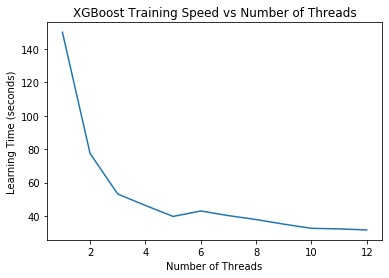

In [35]:
# plot Evaluation results
pyplot.plot(num_threads, results)
pyplot.ylabel('Learning Time (seconds)')
pyplot.xlabel('Number of Threads')
pyplot.title('XGBoost Training Speed vs Number of Threads')
pyplot.show()

#### We can see a nice trend in the decrease in execution time as the number of threads is increased. 

For this local execution we ran this on on a **6-core intel processor, which has a total of 12 cores: 6 physical and an additional 6 virtual cores.***

#### It is interesting to note that we do not see much improvement beyond the no. of physical cores i.e. 6 threads (at about 40 seconds), after which the gains are more or less absent. 

The results suggest that if you have a machine with hyperthreading, you may want to set num_threads to equal the number of physical CPU cores in your machine.

### For Parallel-Cross Validation we can also compare the following scenarios:

In [89]:
# Prepare cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

# Single Thread XGBoost, Parallel Thread CV
start = time.time()
model = XGBClassifier(nthread=1)
results = cross_val_score(model, X, train_labels, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
elapsed = time.time() - start


Single Thread XGBoost, Parallel Thread CV: 365.254714


In [90]:
# Parallel Thread XGBoost, Single Thread CV
start = time.time()
model = XGBClassifier(nthread=-1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=1)
elapsed = time.time() - start
print("Parallel Thread XGBoost, Single Thread CV: %f" % (elapsed))


Parallel Thread XGBoost, Single Thread CV: 394.684315


In [91]:
# Parallel Thread XGBoost and CV
start = time.time()
model = XGBClassifier(nthread=-1)
results = cross_val_score(model, X, label_encoded_y, cv=kfold, scoring='neg_log_loss', n_jobs=-1)
elapsed = time.time() - start
print("Parallel Thread XGBoost and CV: %f" % (elapsed))

Parallel Thread XGBoost and CV: 352.520111


In [93]:
print(results)

[-0.64857141 -0.64966988 -0.65863478 -0.65553963 -0.65221448 -0.65320684
 -0.66513679 -0.64852363 -0.65310605 -0.64974786]


**FEATURE IMPORTANCE**